In [13]:
import numpy as np
import matplotlib.pyplot as plt

import os
import sys
import importlib

os.environ["JAX_ENABLE_X64"] = "true"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ['ENABLE_PJRT_COMPATIBILITY'] = 'false'
os.environ["JAX_PLATFORMS"] = "cpu"

In [14]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
font_axis_label = 16

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    'font.size': 12
})

In [15]:
import jax
from jax.numpy import trace
from jax.numpy.linalg import pinv
from jax.scipy.special import erfc, erfinv

pinv = jax.jit(pinv)
trace = jax.jit(trace)
erfc = jax.jit(erfc)
erfinv = jax.jit(erfinv)
erfcinv = jax.jit(lambda x: erfinv(1-x))

jax.config.update("jax_enable_x64", True)

In [16]:
import src
importlib.import_module(f'src')
for module in dir(src):
    if '__' not in module:
        print(module)
        importlib.import_module(f'src.{module}')
        importlib.reload(sys.modules[f'src.{module}'])
from src.mnist_experiments import GratingImages
from src.model_utils import get_model_activations

linear_problems
manifolds
mnist_experiments
model_utils
solvers
theory_utils


(100, 1200, 1, 64, 64)
torch.Size([10, 100, 1, 64, 64])


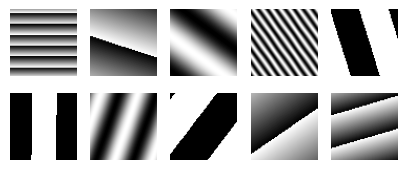

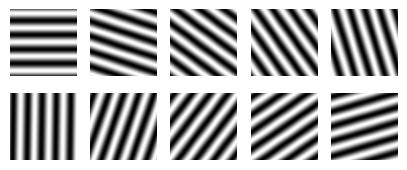

(100, 100, 65536)
(100, 100, 16384)
(100, 100, 8192)
(100, 100, 4096)
(100, 100, 2048)
(100, 100, 1000)


In [17]:
import timm
import torch
max_img_num = 100
random_seed = 42

grating_manifold = GratingImages(max_img_num=max_img_num,
                                 image_size=(64, 64),
                                 max_sample_size=100,
                                 random_seed=random_seed)
angles, manifold = grating_manifold.create_grating_manifold()
grating_manifold.sample_digits()
grating_manifold.sample_manifold()

use_cuda =  torch.cuda.is_available()
use_mps = torch.backends.mps.is_available()

if use_cuda:
    device = torch.device("cuda")
elif use_mps:
    device = torch.device("mps")
else:
    device = torch.device("cpu")

model = timm.create_model('resnet34', pretrained=True, in_chans=1).to(device)
layer_list = ['act1', 'layer1', 'layer2',  'layer3', 'layer4', 'fc']

for layer in layer_list:
    act = get_model_activations(model, layer, manifold, flatten=True, to_numpy=True, rand_proj_dim=None)
    print(act.shape)

In [18]:
def process_data(all_data, save_keys):
    
    from copy import deepcopy

    model_list = ['resnet18', 'resnet34', 'resnet50'
                  ]
    trained_list = ['random', 'trained']
    layer_list = ['conv1', 'layer1', 'layer2',  'layer3', 'layer4']

    all_box_data = []
    for trained in trained_list:
        box_temp1 = []
        for model in model_list:
            box_temp2 = []
            for layer in layer_list:

                d = deepcopy(all_data[trained][model][layer])
                d = d['all_results_th']

                def correct_dict(all_results_th):
                    
                    corrected_th = deepcopy(all_results_th)

                    C = all_results_th['C'][0]
                    Etr = all_results_th['Etr'][0]
                    idx_C = np.abs(np.diff(C, prepend=0)) > 2e-1
                    idx_Etr = Etr > 1e-5

                    correct_keys = ['C', 'Etr', 'alpha_eff', 'epsilon_eff', 'epsilon_th', 'lamb_eff']

                    for i in range(len(C)):
                        if (idx_C[i] or idx_Etr[i]) and i > 35:
                            for key in correct_keys:
                                corrected_th[key][0][i] = corrected_th[key][0][i-1]

                    return corrected_th
                d = correct_dict(d)

                assert len(np.unique(d['E_inf'])) == 1
                d['Etr'] = d['Etr'] * (d['Etr'] > 1e-10)
                d['C'] = d['C'] * (d['C'] > 1e-15)
                d['C'][0] *= (d['Etr'][0] < 1e-15)
                d['epsilon_th'][0] *= (d['Etr'][0] < 1e-5)
                d['epsilon_eff'][0] *= (d['Etr'][0] < 1e-5)
                d['Etr'][0] *= (d['Etr'][0] < 1e-5)

                idx_wrong = d['Etr'][0] > 1e-5
                if idx_wrong.sum():
                    d['C'][0][idx_wrong] = np.nan

                box_temp2 += [[d[key]*np.ones((4, 100)) for key in save_keys]]
            box_temp1 += [box_temp2]
        all_box_data += [box_temp1]

    all_box_data = np.array(all_box_data).swapaxes(0, 3)
    all_box_data_dict = {key: val for key, val in zip(save_keys, all_box_data)}
    return all_box_data_dict

In [19]:
combined_data = np.load('./results/combined_data_grating_dataset.npz', allow_pickle=True)['combined_data'].tolist()

In [20]:
from copy import deepcopy
combined_data_plot = deepcopy(combined_data)

rand_proj_dim_list = combined_data_plot.pop('rand_proj_dim_list')
max_img_num_list = combined_data_plot.pop('max_img_num_list')
sample_size_list = combined_data_plot.pop('sample_size_list')
random_seed_list = combined_data_plot.pop('random_seed_list')

save_keys = ['C', 'Etr', 'alpha', 'alpha_eff', 'epsilon_eff',
             'epsilon_th', 'E_inf', 'lamb_eff', 'Dem', 'Rem', 'ED', 'TAD']

all_box_data = {key: [] for key in save_keys}
for rand_proj_dim in rand_proj_dim_list[:]:
    for max_img_num in max_img_num_list[:]:
        for sample_size in sample_size_list[1:]:
            for seed in random_seed_list[:]:

                all_data = combined_data_plot[rand_proj_dim][max_img_num][sample_size][seed]
                all_box_data_dict = process_data(all_data, save_keys)

                for key, val in all_box_data_dict.items():
                    all_box_data[key] += [deepcopy(val)]


for key, val in all_box_data.items():
    all_box_data[key] = np.array(all_box_data[key])

alpha_list_th = combined_data_plot[50][100][100][42]['random']['resnet18']['conv1']['alpha_list_th']
alpha_list_th.shape

(100,)

alpha 1.3727272727272728
alpha 1.3727272727272728


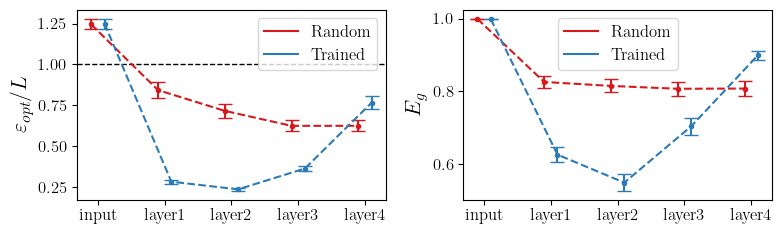

In [21]:
eps_idx = 0
alpha_idx = 15
alpha_idx = 45

fig, axs = plt.subplots(1, 2, figsize=(8, 2.5))
for tr_idx in range(2):

    print(f'alpha {alpha_list_th[alpha_idx]}')
    
    box_data_C = all_box_data['C'].copy()
    box_data_epsilon_th = all_box_data['epsilon_th'].copy()
    box_data_Einf = all_box_data['E_inf'].copy()
    box_data_epsilon_eff = all_box_data['epsilon_eff'].copy()
    box_data_R = all_box_data['Rem'].copy()
    box_data_D = all_box_data['Dem'].copy()
    box_data_ED = all_box_data['ED'].copy()
    box_data_TAD = all_box_data['TAD'].copy()

    data1 = box_data_epsilon_th / 3.4296
    data2 = box_data_C

    if tr_idx == 0:
        trained = 'Precision'
        data_a = data1[:, :, :, 0, eps_idx, alpha_idx]
        data_b = data1[:, :, :, 1, eps_idx, alpha_idx]
        ylabel_txt = r'$\varepsilon_{opt}/L$'
        axs[tr_idx].axhline(1, color='k', ls='--', lw=1)
    elif tr_idx == 1:
        trained = 'Generalization'
        data_a = data2[:, :, :, 0, eps_idx, alpha_idx]
        data_b = data2[:, :, :, 1, eps_idx, alpha_idx]
        ylabel_txt = r'$E_{g}$'
    
    data_a = data_a.reshape(-1, data_a.shape[-1])
    data_b = data_b.reshape(-1, data_b.shape[-1])

    ticks = ['input', 'layer1', 'layer2',  'layer3', 'layer4']

    def set_box_color(bp, color):
        plt.setp(bp['boxes'], color=color)
        plt.setp(bp['whiskers'], color=color)
        plt.setp(bp['caps'], color=color)
        plt.setp(bp['medians'], color=color)

    positions = np.array(range(data_a.shape[1]))*2.0
    bpl_color = '#D7191C'
    bpl_pos = positions - 0.2

    bpr_color = '#2C7BB6'
    bpr_pos = positions + 0.2

    mask = ~np.isnan(data_a)
    data_a = [d[m] for d, m in zip(data_a.T, mask.T)]
    data_a_median = [np.median(m) for m in data_a]
    data_a_mean = [np.mean(m) for m in data_a]
    data_a_std = [np.std(m) for m in data_a]
    data_a_std = [np.std(m)/np.sqrt(len(m)) for m in data_a]

    mask = ~np.isnan(data_b)
    data_b = [d[m] for d, m in zip(data_b.T, mask.T)]
    data_b_median = [np.median(m) for m in data_b]
    data_b_mean = [np.mean(m) for m in data_b]
    data_b_std = [np.std(m) for m in data_b]
    data_b_std = [np.std(m)/np.sqrt(len(m)) for m in data_b]
    
    axs[tr_idx].errorbar(bpl_pos, data_a_mean, data_a_std, fmt='.--', color=bpl_color, capsize=5)
    axs[tr_idx].errorbar(bpr_pos, data_b_mean, data_b_std, fmt='.--', color=bpr_color, capsize=5)

    axs[tr_idx].plot([], c=bpl_color, label='Random')
    axs[tr_idx].plot([], c=bpr_color, label='Trained')
    axs[tr_idx].legend()

    axs[tr_idx].set_xticks(range(0, len(ticks) * 2, 2), ticks, fontsize=12)
    axs[tr_idx].set_ylabel(ylabel_txt, fontsize=16)

plt.tight_layout()
plt.savefig(f'./figures/grating_experiment_alpha_{alpha_idx}.pdf')

alpha 1.3727272727272728
alpha 1.3727272727272728


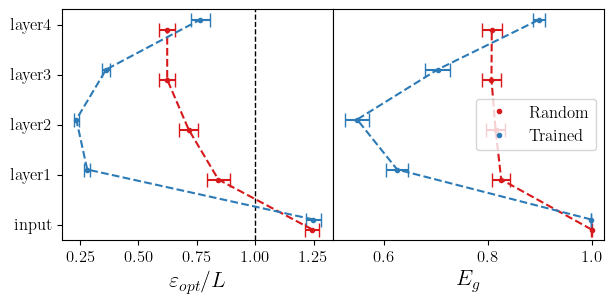

In [22]:
eps_idx = 0
alpha_idx = 15
alpha_idx = 45
# alpha_idx = -10

fig, axs = plt.subplots(1, 2, figsize=(7, 3), sharey=True)
fig.subplots_adjust(hspace=0, wspace=0)
for tr_idx in range(2):

    print(f'alpha {alpha_list_th[alpha_idx]}')

    box_data_C = all_box_data['C'].copy()
    box_data_epsilon_th = all_box_data['epsilon_th'].copy()
    box_data_Einf = all_box_data['E_inf'].copy()
    box_data_epsilon_eff = all_box_data['epsilon_eff'].copy()
    box_data_R = all_box_data['Rem'].copy()
    box_data_D = all_box_data['Dem'].copy()
    box_data_ED = all_box_data['ED'].copy()
    box_data_TAD = all_box_data['TAD'].copy()

    data1 = box_data_epsilon_th / 3.4296
    data2 = box_data_C

    if tr_idx == 0:
        trained = 'Precision'
        data_a = data1[:, :, :, 0, eps_idx, alpha_idx]
        data_b = data1[:, :, :, 1, eps_idx, alpha_idx]
        ylabel_txt = r'$\varepsilon_{opt}/L$'
        axs[tr_idx].axvline(1, color='k', ls='--', lw=1)
    elif tr_idx == 1:
        trained = 'Generalization'
        data_a = data2[:, :, :, 0, eps_idx, alpha_idx]
        data_b = data2[:, :, :, 1, eps_idx, alpha_idx]
        ylabel_txt = r'$E_{g}$'

    data_a = data_a.reshape(-1, data_a.shape[-1])
    data_b = data_b.reshape(-1, data_b.shape[-1])

    ticks = ['input', 'layer1', 'layer2',  'layer3', 'layer4']

    def set_box_color(bp, color):
        plt.setp(bp['boxes'], color=color)
        plt.setp(bp['whiskers'], color=color)
        plt.setp(bp['caps'], color=color)
        plt.setp(bp['medians'], color=color)

    positions = np.array(range(data_a.shape[1]))*2.0
    bpl_color = '#D7191C'
    bpl_pos = positions - 0.2

    bpr_color = '#2C7BB6'
    bpr_pos = positions + 0.2

    mask = ~np.isnan(data_a)
    data_a = [d[m] for d, m in zip(data_a.T, mask.T)]
    data_a_median = [np.median(m) for m in data_a]
    data_a_mean = [np.mean(m) for m in data_a]
    data_a_std = [np.std(m) for m in data_a]
    data_a_std = [np.std(m)/np.sqrt(len(m)) for m in data_a]

    mask = ~np.isnan(data_b)
    data_b = [d[m] for d, m in zip(data_b.T, mask.T)]
    data_b_median = [np.median(m) for m in data_b]
    data_b_mean = [np.mean(m) for m in data_b]
    data_b_std = [np.std(m) for m in data_b]
    data_b_std = [np.std(m)/np.sqrt(len(m)) for m in data_b]

    axs[tr_idx].errorbar(data_a_mean, bpl_pos, xerr=data_a_std, fmt='.--', color=bpl_color, capsize=5)
    axs[tr_idx].errorbar(data_b_mean, bpr_pos, xerr=data_b_std, fmt='.--', color=bpr_color, capsize=5)

    axs[tr_idx].plot([], ".", c=bpl_color, label='Random')
    axs[tr_idx].plot([], ".", c=bpr_color, label='Trained')

    axs[tr_idx].set_yticks(range(0, len(ticks) * 2, 2), ticks, fontsize=12)
    axs[tr_idx].set_xlabel(ylabel_txt, fontsize=16)

axs[1].legend(loc='center right')
plt.tick_params(axis='y', left=False, labelleft=False)
plt.savefig(f'./figures/grating_experiment_alpha_{alpha_idx}_T.pdf')

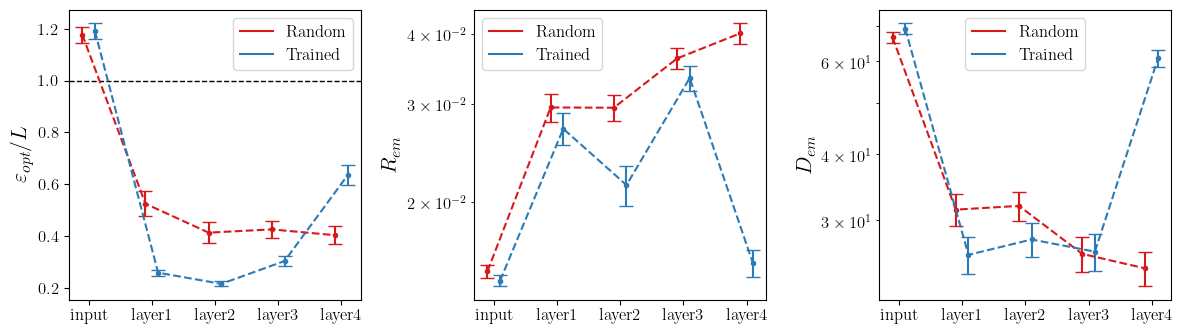

In [23]:
eps_idx = 0
alpha_idx = 15
alpha_idx = 45

fig, axs = plt.subplots(1, 3, figsize=(12, 3.5))
for tr_idx in range(3):

    box_data_C = all_box_data['C'].copy()
    box_data_epsilon_th = all_box_data['epsilon_th'].copy()
    box_data_Einf = all_box_data['E_inf'].copy()
    box_data_epsilon_eff = all_box_data['epsilon_eff'].copy()
    box_data_R = all_box_data['Rem'].copy()
    box_data_D = all_box_data['Dem'].copy()
    box_data_ED = all_box_data['ED'].copy()
    box_data_TAD = all_box_data['TAD'].copy()

    data1 = box_data_epsilon_th / 3.4296
    data2 = box_data_C / np.sqrt(box_data_D)
    data3 = np.sqrt(box_data_D)

    if tr_idx == 0:
        trained = 'Precision'
        data_a = data1[:, :, :, 0, eps_idx, alpha_idx]
        data_b = data1[:, :, :, 1, eps_idx, alpha_idx]
        ylabel_txt = r'$\varepsilon_{opt}/L$'
        axs[tr_idx].axhline(1, color='k', ls='--', lw=1)
    elif tr_idx == 1:
        trained = 'Radius'
        data_a = data2[:, :, :, 0, eps_idx, alpha_idx]
        data_b = data2[:, :, :, 1, eps_idx, alpha_idx]
        ylabel_txt = r'$R_{em}$'
    else:
        trained = 'Dimensionality'
        data_a = data3[:, :, :, 0, eps_idx, alpha_idx]
        data_b = data3[:, :, :, 1, eps_idx, alpha_idx]
        ylabel_txt = r'$D_{em}$'

    data_a = data_a.reshape(-1, data_a.shape[-1])
    data_b = data_b.reshape(-1, data_b.shape[-1])

    ticks = ['input', 'layer1', 'layer2',  'layer3', 'layer4']

    def set_box_color(bp, color):
        plt.setp(bp['boxes'], color=color)
        plt.setp(bp['whiskers'], color=color)
        plt.setp(bp['caps'], color=color)
        plt.setp(bp['medians'], color=color)

    positions = np.array(range(data_a.shape[1]))*2.0
    bpl_color = '#D7191C'
    bpl_pos = positions - 0.2

    bpr_color = '#2C7BB6'
    bpr_pos = positions + 0.2

    mask = ~np.isnan(data_a)
    data_a = [d[m] for d, m in zip(data_a.T, mask.T)]
    data_a_median = [np.median(m) for m in data_a]
    data_a_std = [np.std(m) for m in data_a]
    data_a_std = [np.std(m)/np.sqrt(len(m)) for m in data_a]

    mask = ~np.isnan(data_b)
    data_b = [d[m] for d, m in zip(data_b.T, mask.T)]
    data_b_median = [np.median(m) for m in data_b]
    data_b_std = [np.std(m) for m in data_b]
    data_b_std = [np.std(m)/np.sqrt(len(m)) for m in data_b]
    
    axs[tr_idx].errorbar(bpl_pos, data_a_median, data_a_std, fmt='.--', color=bpl_color, capsize=5)
    axs[tr_idx].errorbar(bpr_pos, data_b_median, data_b_std, fmt='.--', color=bpr_color, capsize=5)

    axs[tr_idx].plot([], c=bpl_color, label='Random')
    axs[tr_idx].plot([], c=bpr_color, label='Trained')
    axs[tr_idx].legend()

    axs[tr_idx].set_xticks(range(0, len(ticks) * 2, 2), ticks, fontsize=12)
    axs[tr_idx].set_ylabel(ylabel_txt, fontsize=16)

axs[1].set_yscale('log')
axs[2].set_yscale('log')
plt.tight_layout()
plt.savefig(f'./figures/grating_experiment_alpha_{alpha_idx}_error_mode.pdf')

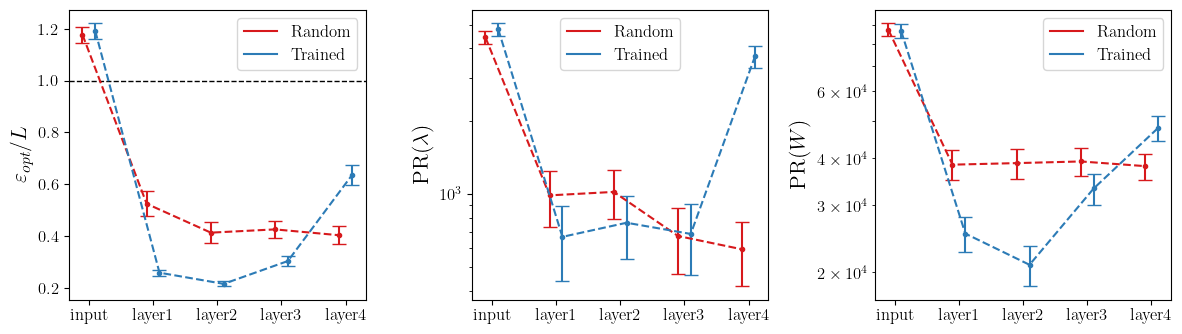

In [24]:
eps_idx = 0
alpha_idx = 15
alpha_idx = 45

fig, axs = plt.subplots(1, 3, figsize=(12, 3.5))
for tr_idx in range(3):

    box_data_C = all_box_data['C'].copy()
    box_data_epsilon_th = all_box_data['epsilon_th'].copy()
    box_data_Einf = all_box_data['E_inf'].copy()
    box_data_epsilon_eff = all_box_data['epsilon_eff'].copy()
    box_data_R = all_box_data['Rem'].copy()
    box_data_D = all_box_data['Dem'].copy()
    box_data_ED = all_box_data['ED'].copy()
    box_data_TAD = all_box_data['TAD'].copy()


    data1 = box_data_epsilon_th / 3.4296
    data2 = box_data_C / np.sqrt(box_data_D)
    data3 = np.sqrt(box_data_D)
    
    data2 = box_data_D 
    data3 = box_data_TAD

    if tr_idx == 0:
        trained = 'Precision'
        data_a = data1[:, :, :, 0, eps_idx, alpha_idx]
        data_b = data1[:, :, :, 1, eps_idx, alpha_idx]
        ylabel_txt = r'$\varepsilon_{opt}/L$'
        axs[tr_idx].axhline(1, color='k', ls='--', lw=1)
    elif tr_idx == 1:
        trained = 'Effective Dimensionality'
        data_a = data2[:, :, :, 0, eps_idx, alpha_idx]
        data_b = data2[:, :, :, 1, eps_idx, alpha_idx]
        ylabel_txt = r'PR$(\lambda)$'
    else:
        trained = 'Dimensionality'
        data_a = data3[:, :, :, 0, eps_idx, alpha_idx]
        data_b = data3[:, :, :, 1, eps_idx, alpha_idx]
        ylabel_txt = r'PR$(W)$'

    data_a = data_a.reshape(-1, data_a.shape[-1])
    data_b = data_b.reshape(-1, data_b.shape[-1])

    ticks = ['input', 'layer1', 'layer2',  'layer3', 'layer4']

    def set_box_color(bp, color):
        plt.setp(bp['boxes'], color=color)
        plt.setp(bp['whiskers'], color=color)
        plt.setp(bp['caps'], color=color)
        plt.setp(bp['medians'], color=color)

    positions = np.array(range(data_a.shape[1]))*2.0
    bpl_color = '#D7191C'
    bpl_pos = positions - 0.2

    bpr_color = '#2C7BB6'
    bpr_pos = positions + 0.2

    mask = ~np.isnan(data_a)
    data_a = [d[m] for d, m in zip(data_a.T, mask.T)]
    data_a_median = [np.median(m) for m in data_a]
    data_a_std = [np.std(m) for m in data_a]
    data_a_std = [np.std(m)/np.sqrt(len(m)) for m in data_a]

    mask = ~np.isnan(data_b)
    data_b = [d[m] for d, m in zip(data_b.T, mask.T)]
    data_b_median = [np.median(m) for m in data_b]
    data_b_std = [np.std(m) for m in data_b]
    data_b_std = [np.std(m)/np.sqrt(len(m)) for m in data_b]
    
    axs[tr_idx].errorbar(bpl_pos, data_a_median, data_a_std, fmt='.--', color=bpl_color, capsize=5)
    axs[tr_idx].errorbar(bpr_pos, data_b_median, data_b_std, fmt='.--', color=bpr_color, capsize=5)

    axs[tr_idx].plot([], c=bpl_color, label='Random')
    axs[tr_idx].plot([], c=bpr_color, label='Trained')
    axs[tr_idx].legend()

    axs[tr_idx].set_xticks(range(0, len(ticks) * 2, 2), ticks, fontsize=12)
    axs[tr_idx].set_ylabel(ylabel_txt, fontsize=16)

axs[1].set_yscale('log')
axs[2].set_yscale('log')
plt.tight_layout()
plt.savefig(f'./figures/grating_experiment_alpha_{alpha_idx}_ed_tad.pdf')